In [2]:
using Pkg
cd("../..")
Pkg.activate(".")

 Activating environment at `C:\Users\pawel\Documents\MeshRefiner\Project.toml`


In [3]:
pwd()

"C:\\Users\\pawel\\Documents\\MeshRefiner"

In [4]:
import Makie
using LinearAlgebra
import MeshRefiner
using LightGraphs, MetaGraphs

┌ Info: Precompiling MeshRefiner [c6b4437b-488c-4e50-b87c-bc559683b7d5]
└ @ Base loading.jl:1260


In [5]:
function get_matrix(v1, v2, v3)
    vx = v2 - v1
    vy = v3 - v1
    translate = v1
    scalex = norm(vx)
    scaley = norm(vy)
    vx = normalize(vx)
    vy = normalize(vy)
    
    S = [
        1.0/scalex 0.0 0.0;
        0.0 1.0/scaley 0.0;
        0.0 0.0 1.0;
    ]
    R = hcat(vcat(vx, 0), vcat(vy, 0), [0,0,1])
    R = transpose(R)
    T = hcat([1,0,0], [0,1,0], vcat(-translate, 1))
    return S*R*T
#     return R
end

get_matrix (generic function with 1 method)

In [6]:
trans_coor(v, M) = (M*vcat(v,1))[1:2]

trans_coor (generic function with 1 method)

In [7]:
Makie.AbstractPlotting.inline!(true)

false

In [8]:
max_from(array...) = maximum(vcat(array...))

max_from (generic function with 1 method)

In [9]:
function draw_triangle(v1, v2, v3, max_coor=nothing::Union{Nothing, Number})
    M = hcat(v1,v2,v3)
    x = M[1,:]
    y = M[2,:]
    
    if max_coor != nothing
        limits = Makie.FRect((0,0), tuple(max_coor, max_coor))
    else
        max_val = max_from(x, y)
        limits = Makie.FRect((0, 0), (max_val, max_val))
    end

    e1 = [Makie.Point2f0(v1), Makie.Point2f0(v2)]
    e2 = [Makie.Point2f0(v1), Makie.Point2f0(v3)]
    e3 = [Makie.Point2f0(v2), Makie.Point2f0(v3)]
    scene = Makie.scatter(x, y, limits=limits, resolution = (600, 600))
    Makie.linesegments!(scene, e1)
    Makie.linesegments!(scene, e2)
    Makie.linesegments!(scene, e3)
    return scene
end

draw_triangle (generic function with 2 methods)

# Jak to działa

In [10]:
v1 = [3.0,2.0]
v2 = [1.0,4.0]
v3 = [6.0,5.0]

2-element Array{Float64,1}:
 6.0
 5.0

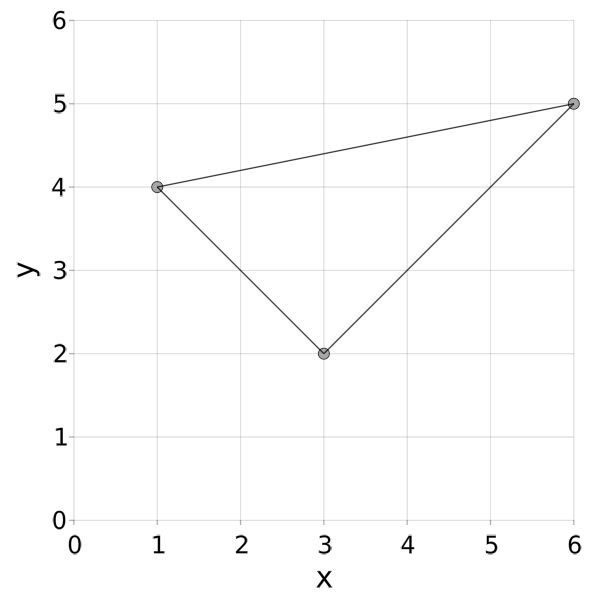

In [11]:
draw_triangle(v1,v2,v3)

In [12]:
M = get_matrix(v1,v2,v3)

3×3 Array{Float64,2}:
 -0.25      0.25       0.25
  0.166667  0.166667  -0.833333
  0.0       0.0        1.0

In [13]:
_v1 = trans_coor(v1, M)
_v2 = trans_coor(v2, M)
_v3 = trans_coor(v3, M)

2-element Array{Float64,1}:
 1.1102230246251565e-16
 1.0

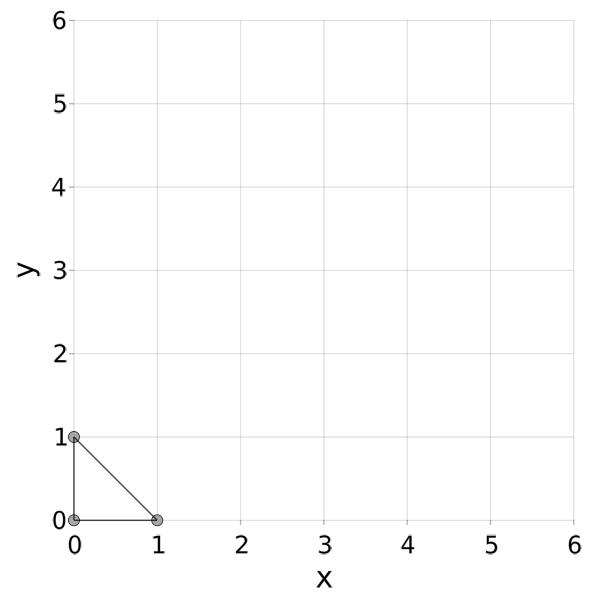

In [14]:
draw_triangle(_v1,_v2,_v3, max_from(v1,v2,v3))

# Funkcje

In [15]:
ρ = 100

100

In [16]:
u(x, y) = (x + (ℯ^(ρ*x)-1) / (1-ℯ^ρ))*(y + (ℯ^(ρ*y)-1) / (1-ℯ^ρ))

u (generic function with 1 method)

In [17]:
u(vec) = u(vec[1], vec[2])

u (generic function with 2 methods)

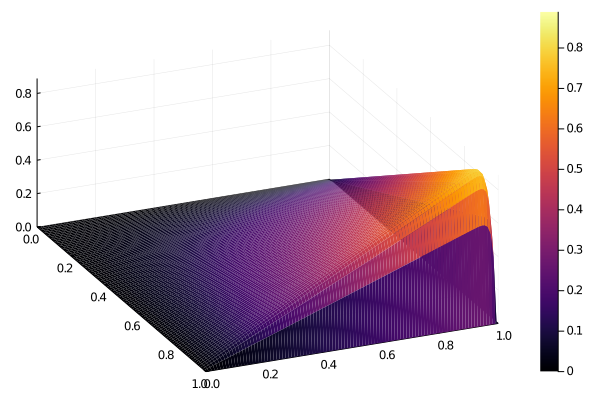

In [18]:
using Plots
x=range(0,stop=1,length=100)
y=range(0,stop=1,length=100)
plot(x,y,u,st=:surface,camera=(-30,30))

In [19]:
u(0.9, 0.9)

0.8099182821875812

In [20]:
phi1(x, y) = x
phi2(x, y) = y
phi3(x, y) = 1 - x - y

phi3 (generic function with 1 method)

In [21]:
phi1(vec) = vec[1]
phi2(vec) = vec[2]
phi3(vec) = 1 - vec[1] - vec[2]

phi3 (generic function with 2 methods)

In [22]:
get_coor(g, v) = [get_prop(g, v, :x), get_prop(g, v, :y)]

get_coor (generic function with 1 method)

In [23]:
function ortho_order(g, i)
    v1 = get_prop(g, i, :v1)
    v2 = get_prop(g, i, :v2)
    v3 = get_prop(g, i, :v3)
    v1coor = get_coor(g, v1)
    v2coor = get_coor(g, v2)
    v3coor = get_coor(g, v3)
    if dot(v2coor - v1coor, v3coor - v1coor) == 0
        return v1, v2, v3
    end
    if dot(v3coor - v2coor, v1coor - v2coor) == 0
        return v2, v1, v3
    end
    if dot(v1coor - v3coor, v2coor - v3coor) == 0
        return v3, v1, v2
    end
    return nothing
end

ortho_order (generic function with 1 method)

In [34]:
function error_rel(g, fun, i)
    v1, v2, v3 = ortho_order(g, i)
    # Now right angle is in vertex v1
    
    v1coor = [get_prop(g, v1, :x), get_prop(g, v1, :y)]
    v2coor = [get_prop(g, v2, :x), get_prop(g, v2, :y)]
    v3coor = [get_prop(g, v3, :x), get_prop(g, v3, :y)]
    
    # Actually I don't even need that
    M = get_matrix(v1coor, v2coor, v3coor)
    v1coor_t = trans_coor(v1coor, M)
    v2coor_t = trans_coor(v2coor, M)
    v3coor_t = trans_coor(v3coor, M)
    
    a1 = get_prop(g, v1, :value)
    a2 = get_prop(g, v2, :value)
    a3 = get_prop(g, v3, :value)
    
    center = (v1coor + v2coor + v3coor) / 3.0
    center_t = [1.0/3.0, 1.0/3.0]
#     uh = a1*phi1(center_t) + a2*phi2(center_t) + a3*phi3(center_t)
#     print(phi1(center_t), "  ", phi2(center_t), "  ", phi3(center_t))
    uh = (a1 + a2 + a3) / 3.0
    return (u(center) - uh)^2 / u(center)^2
end

error_rel (generic function with 1 method)

In [35]:
get_vertices(g) = filter_vertices(g, (g, v) -> (if get_prop(g, v, :type) == "vertex" true else false end))

get_vertices (generic function with 1 method)

In [36]:
get_interiors(g) = filter_vertices(g, (g, v) -> (if get_prop(g, v, :type) == "interior" true else false end))

get_interiors (generic function with 1 method)

In [37]:
function match_to_fun!(g, fun)
    for v in get_vertices(g)
        set_prop!(g, v, :value, fun(get_prop(g, v, :x), get_prop(g, v, :y)))
    end
end

match_to_fun! (generic function with 1 method)

# Adaptacja

In [38]:
g = MeshRefiner.simple_graph()

{6, 5} undirected Int64 metagraph with Float64 weights defined by :weight (default weight 1.0)

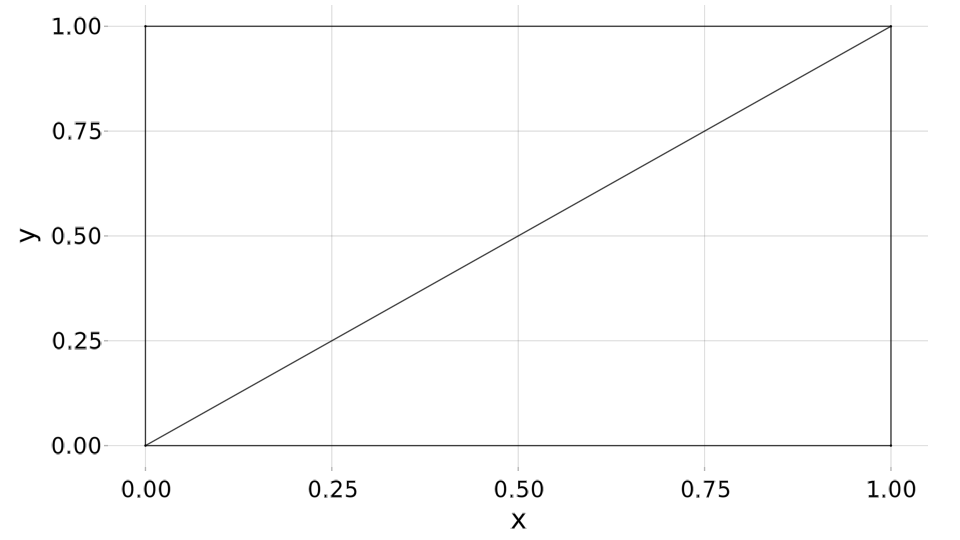

In [39]:
MeshRefiner.draw_makie(g)

In [41]:
max_error = 0
match_to_fun!(g, u)
for i = 1:10
    for e in get_interiors(g)
        error = error_rel(g, u, e)
        set_prop!(g, e, :error, error)
        max_error = max(max_error, error)
    end
    
    for e in get_interiors(g)
        error = get_prop(g, e, :error)
        if (error) > 0.33 * max_error
            set_prop!(g, e, :refine, true)
        end
    end
    
    MeshRefiner.run_transformations!(g)
    match_to_fun!(g, u)
end

In [42]:
for e in 1:nv(g)
    if get_prop(g, e, :type) == "hanging"
        println(e)
        stop = true
    end
end

In [43]:
MeshRefiner.run_transformations!(g)

false

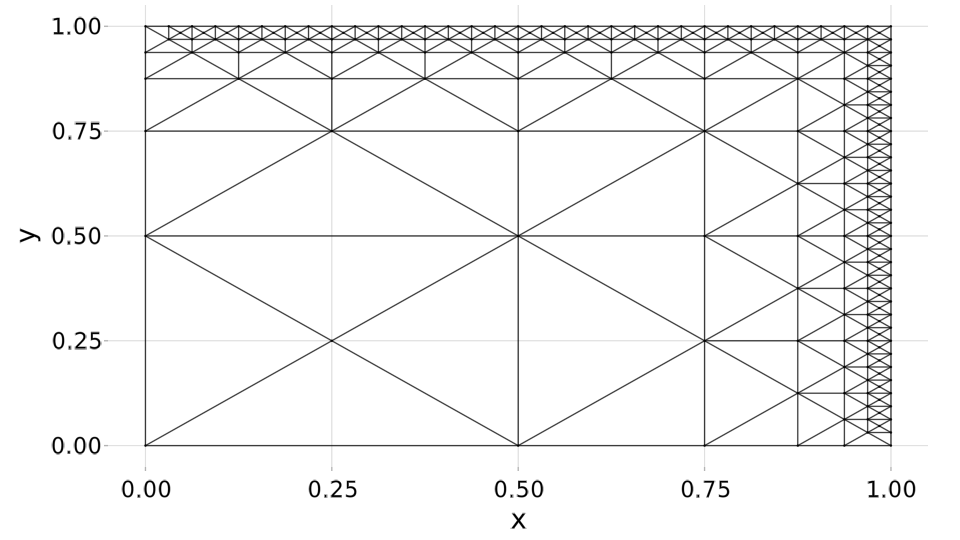

In [44]:
MeshRefiner.draw_makie(g)

# Test

In [121]:
MeshRefiner.interior_vertices(g, 64)

3-element Array{Int64,1}:
  63
 279
 279

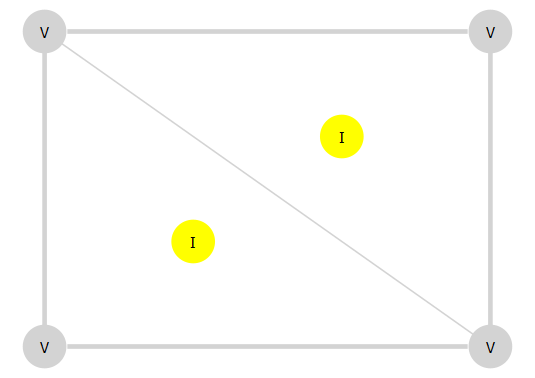

In [118]:
g1 = MeshRefiner.simple_graph()
MeshRefiner.draw_graphplot(g1)

# Junk

In [267]:
v1 = [1, 3]
v2 = [2, 6]
v3 = [5, 4]

2-element Array{Int64,1}:
 5
 4

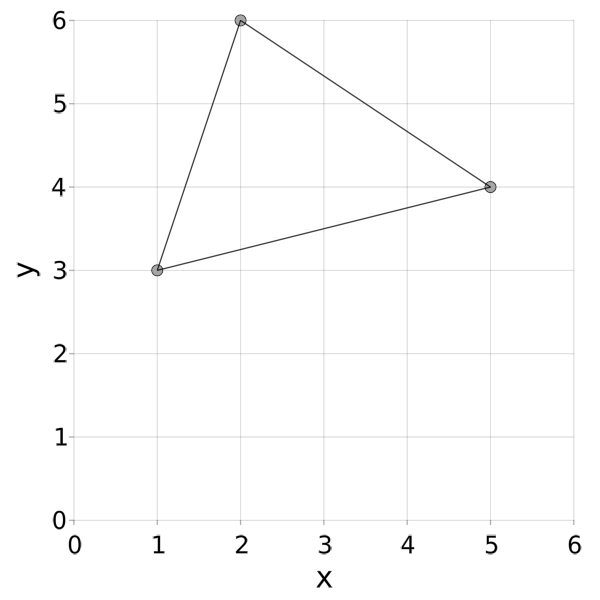

In [268]:
draw_triangle(v1, v2, v3)

In [269]:
M = get_matrix(v1,v2,v3)

3×3 Transpose{Float64,Array{Float64,2}}:
 0.316228  0.948683  0.0
 0.970143  0.242536  0.0
 0.0       0.0       1.0

In [270]:
_v1 = trans_coor(v1, M)
_v2 = trans_coor(v2, M)
_v3 = trans_coor(v3, M)

2-element Array{Float64,1}:
 5.375872022286245
 5.820855000871992

In [276]:
dot(normalize(_v1-_v2), normalize(_v3-_v2))

-0.11956852997615808

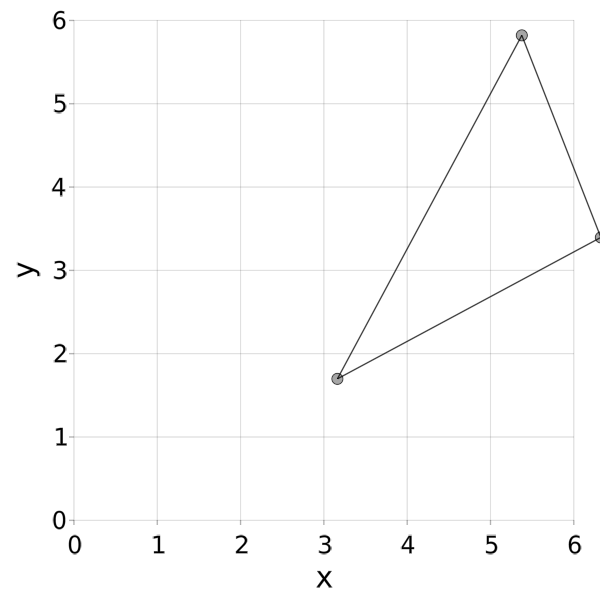

In [271]:
draw_triangle(_v1,_v2,_v3, max_from(v1,v2,v3))

In [211]:
g = MeshRefiner.simple_graph()

{6, 5} undirected Int64 metagraph with Float64 weights defined by :weight (default weight 1.0)

In [248]:
g1 = MetaGraph()
MeshRefiner.add_meta_vertex!(g1, 0.3, 0.8, 0.0)
MeshRefiner.add_meta_vertex!(g1, 0.9, 0.2, 0.0)
MeshRefiner.add_meta_vertex!(g1, 0.9, 0.8, 0.0)
MeshRefiner.add_meta_edge!(g1, 1, 2, true)
MeshRefiner.add_meta_edge!(g1, 1, 3, true)
MeshRefiner.add_meta_edge!(g1, 2, 3, true)
MeshRefiner.add_interior!(g1, 1, 2, 3, false)

4

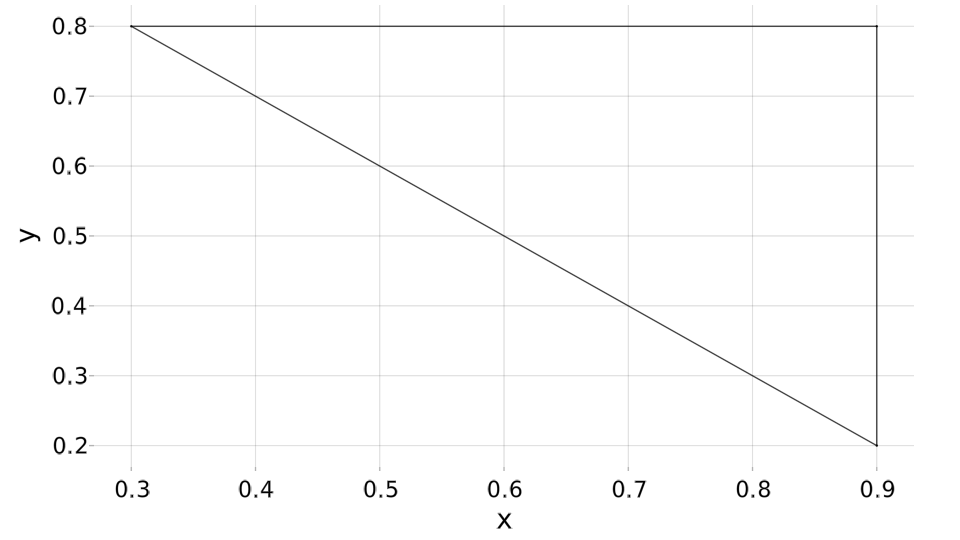

In [249]:
MeshRefiner.draw_makie(g1)

In [228]:
match_to_fun!(g1, u)

In [252]:
set_prop!(g1, 1, :value, 1)
set_prop!(g1, 2, :value, 2)
set_prop!(g1, 3, :value, 0.5)

true

In [253]:
v1, v2, v3 = ortho_order(g1, 4)

a1 = get_prop(g1, v1, :value)
a2 = get_prop(g1, v2, :value)
a3 = get_prop(g1, v3, :value)

center_t = [1.0/3.0, 1.0/3.0]
uh = a1*phi1(center_t) + a2*phi2(center_t) + a3*phi3(center_t)

1.166666666666667

In [237]:
u(center_t)

0.11029442429055752

In [229]:
get_prop(g1, 1, :value)

0.2115647379593375

In [231]:
u(get_prop(g1, 1, :x), get_prop(g1, 1, :y))

0.2115647379593375

In [219]:
error_rel(g, nothing, 5)

UndefVarError: UndefVarError: g not defined

In [220]:
scene = MeshRefiner.draw_makie(g)

UndefVarError: UndefVarError: g not defined

In [222]:
x

0.0:0.010101010101010102:1.0